In [1]:
import xarray as xr
import numpy as np
from collections import namedtuple
import regionmask
import datetime
import pandas as pd
from scores.continuous import rmse
import matplotlib.pyplot as plt

# Permutation Notes

As I'm writing out the MWE's, here's some notes on what I think might need to be accounted for:

1. Models that run every 3, 6, 12, 24 hours and how that translates to the max/min metrics (all valid times in a 12 hour frequency/6 hour resolution have 21 lead times, for example, compared to 6/6 runs with 41)
2. When to aggregate over lat/lons for area-averaged metrics
3. When to remove ocean gridpoints to avoid improper comparisons (e.g. forecasts spatially aggregated with ocean vs ERA5 aggregated without)
4. I am using a stand-in value of >= 2 days 20C minimum temp for the "heatwave". The start and end dates on the case are the analyzed heat wave, but the same needs to be determined in the models for onset and duration ME. We determined >= 2 days where the minimum temperature > 85th percentile is a heat wave case (EPA definition). There is scaffolding needed to pull in the 85th percentile climatology from the bucket. Also, the edge cases of: no heat wave, fragmented heat wave, heat waves in the wrong timeframe, and "never ending heat wave" (e.g. fills the whole forecast).

In [40]:
def wind_speed_direction_to_uv(wind_speed: xr.DataArray, wind_direction: xr.DataArray) -> tuple[xr.DataArray, xr.DataArray]:
    """Convert wind speed and direction to u and v components.
    
    Args:
        wind_speed: The wind speed DataArray.
        wind_direction: The wind direction DataArray.
    """ 
    u = -wind_speed * np.sin(np.deg2rad(wind_direction))
    v = -wind_speed * np.cos(np.deg2rad(wind_direction))

    return u, v

def convert_longitude_to_360(longitude: float) -> float:
    """Convert a longitude from the range [-180, 180) to [0, 360)."""
    return np.mod(longitude, 360)

def lead_time_init_time_to_valid_time(forecast):
    """Convert init_time and lead_time to valid_time.
    
    Args:
        forecast: The forecast dataset.

    Returns:
        The forecast dataset with valid_time dimension.
    """
    if 'lead_time' not in forecast.dims or 'init_time' not in forecast.dims:
        raise ValueError("lead_time and init_time must be dimensions of the forecast dataset")
    
    lead_time_grid, init_time_grid = np.meshgrid(forecast.lead_time, forecast.init_time)
    valid_times = (
    init_time_grid.flatten()
    + pd.to_timedelta(lead_time_grid.flatten(), unit="h").to_numpy()
    )
    return valid_times

# Subset timesteps for forecast
def derive_indices_from_init_time_and_lead_time(
    dataset: xr.Dataset,
    start_date: datetime.datetime,
    end_date: datetime.datetime,
) -> np.ndarray:
    """Derive the indices of valid times in a dataset when the dataset has init_time and lead_time coordinates.

    Args:
        dataset: The dataset to derive the indices from.
        start_date: The start date to derive the indices from.
        end_date: The end date to derive the indices from.

    Returns:
        The indices of valid times in the dataset.

    Example:
        >>> import xarray as xr
        >>> import datetime
        >>> import pandas as pd
        >>> from extremeweatherbench.utils import (
        ...     derive_indices_from_init_time_and_lead_time,
        ... )
        >>> ds = xr.Dataset(
        ...     coords={
        ...         "init_time": pd.date_range("2020-01-01", "2020-01-03"),
        ...         "lead_time": [0, 24, 48],  # hours
        ...     }
        ... )
        >>> start = datetime.datetime(2020, 1, 1)
        >>> end = datetime.datetime(2020, 1, 4)
        >>> indices = derive_indices_from_init_time_and_lead_time(ds, start, end)
        >>> print(indices)
        array([0, 0, 1, 1, 2])
    """
    valid_times = lead_time_init_time_to_valid_time(dataset)
    valid_times_reshaped = valid_times.reshape(
        (
            dataset.init_time.shape[0],
            dataset.lead_time.shape[0],
        )
    )
    valid_time_mask = (valid_times_reshaped > pd.to_datetime(start_date)) & (
        valid_times_reshaped < pd.to_datetime(end_date)
    )
    valid_time_indices = np.asarray(valid_time_mask).nonzero()

    # The first index will subset init_time based on the first valid_time_reshaped line above
    # we don't need to subset lead_time but it might be useful in the future
    init_time_subset_indices = valid_time_indices[0]

    return init_time_subset_indices

def remove_ocean_gridpoints(dataset: xr.Dataset,drop: bool = True) -> xr.Dataset:
    """Subset a dataset to only include land gridpoints based on a land-sea mask.

    Args:
        dataset: The input xarray dataset.

    Returns:
        The dataset masked to only land gridpoints.
    """
    land = regionmask.defined_regions.natural_earth_v5_0_0.land_110
    land_sea_mask = land.mask(dataset.longitude, dataset.latitude)
    land_mask = land_sea_mask == 0
    # Subset the dataset to only include land gridpoints
    return dataset.where(land_mask, drop=drop)


In [5]:
#event metadata
start_date = pd.Timestamp('2021-02-10 12:00:00')
end_date = pd.Timestamp('2021-02-22 12:00:00')
Location = namedtuple('Location', ['latitude', 'longitude'])
location = Location(latitude=30.2672, longitude=-97.7431)
bounding_box_degrees = 5
variables = ['surface_air_temperature','surface_eastward_wind','surface_northward_wind']

In [11]:
ghcn_ds

<xarray.Dataset> Size: 3MB
Dimensions:                           (location: 79, valid_time: 385)
Coordinates:
    station                           (location) object 632B 'USI0000KCZT' .....
  * valid_time                        (valid_time) datetime64[ns] 3kB 2021-02...
  * location                          (location) object 632B MultiIndex
  * latitude                          (location) float64 632B 28.52 ... 31.15
  * longitude                         (location) float64 632B 260.2 ... 262.6
Data variables:
    name                              (location, valid_time) object 243kB 'DI...
    elevation                         (location, valid_time) float64 243kB 18...
    surface_air_temperature           (location, valid_time) float64 243kB 15...
    surface_air_pressure              (location, valid_time) float64 243kB na...
    air_pressure_at_mean_sea_level    (location, valid_time) float64 243kB na...
    accumulated_1_hour_precipitation  (location, valid_time) float64 243kB na...
    surface_wind_speed                (location, valid_time) float64 243kB 1....
    surface_wind_from_direction       (location, valid_time) float64 243kB 12...
    surface_dew_point                 (location, valid_time) float64 243kB 12...
    surface_relative_humidity         (location, valid_time) float64 243kB 82...
    hour_dist                         (location, valid_time) float64 243kB 5....

In [13]:
#: Storage location for GHCN.
GHCN_URI = "gs://extremeweatherbench/datasets/ghcnh.parq"#Parquet filters
filters = [('time', '>=', start_date - pd.Timedelta(days=2)),
           ('time', '<=', end_date + pd.Timedelta(days=2)),
           ('latitude', '<=', location.latitude+bounding_box_degrees/2),
           ('latitude', '>=', location.latitude-bounding_box_degrees/2),
           ('longitude', '<=', location.longitude+bounding_box_degrees/2),
           ('longitude', '>=', location.longitude-bounding_box_degrees/2)]
ghcn = pd.read_parquet(GHCN_URI, storage_options=dict(token="anon"),filters=filters).set_index(
[
    "station",
    "time"
]
).sort_index()

#Convert parquet to dataset

ghcn_ds = xr.Dataset.from_dataframe(ghcn)
ghcn_ds['latitude'] = ghcn_ds['latitude'].where(ghcn_ds['latitude'].notnull()).bfill(dim='time').isel(time=0)
ghcn_ds['longitude'] = ghcn_ds['longitude'].where(ghcn_ds['longitude'].notnull()).bfill(dim='time').isel(time=0)
ghcn_ds = ghcn_ds.assign_coords(latitude=ghcn_ds.latitude.astype(float), longitude=ghcn_ds.longitude.astype(float)) 
ghcn_ds['longitude'] = convert_longitude_to_360(ghcn_ds['longitude'])
ghcn_ds = ghcn_ds.rename({'time':'valid_time'}).swap_dims({'station': 'location'}).set_index(location=('latitude','longitude'))
prepared_ghcn = ghcn_ds[['surface_air_temperature','surface_wind_speed','surface_wind_from_direction']].rename({'surface_air_temperature':'2m_temperature'})
prepared_ghcn['2m_temperature'] = prepared_ghcn['2m_temperature']+273.15

In [22]:
#: Storage location for ERA5.
ERA5_URI = "gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3"
era5 = xr.open_zarr(
    ERA5_URI,
    chunks=None,
    storage_options=dict(token="anon"),
)
#Convert ERA5 to event dates
era5_case = era5.sel(
    time=slice(
        start_date,
        end_date,
    )
)

#Take freeze variables; named differently between era5, ghcn observations and forecasts
era5_case = era5_case[['2m_temperature','10m_u_component_of_wind','10m_v_component_of_wind']]

era5_case = era5_case.sel(
    latitude=slice(location.latitude+bounding_box_degrees/2,location.latitude-bounding_box_degrees/2),
    longitude=slice(convert_longitude_to_360(location.longitude)-bounding_box_degrees/2, convert_longitude_to_360(location.longitude)+bounding_box_degrees/2)
).rename({'time':'valid_time'})

prepared_era5 = remove_ocean_gridpoints(era5_case,drop=False)

In [16]:
# Forecast
forecast_dir = "gs://weatherbench2/datasets/hres/2016-2022-0012-1440x721.zarr"
forecast_ds = xr.open_zarr(forecast_dir, chunks="auto")
forecast_ds = forecast_ds.rename({'prediction_timedelta':'lead_time','time':'init_time'})

#HRES reverse of ERA5 for latitude slicing
forecast_case = forecast_ds[['2m_temperature','10m_u_component_of_wind','10m_v_component_of_wind']]
forecast_case = forecast_case.sel(
    latitude=slice(location.latitude-bounding_box_degrees/2,location.latitude+bounding_box_degrees/2),
    longitude=slice(convert_longitude_to_360(location.longitude)-bounding_box_degrees/2, convert_longitude_to_360(location.longitude)+bounding_box_degrees/2)
)

valid_times = lead_time_init_time_to_valid_time(forecast_case)
# Create new dataset with valid_time dimension
subset_forecast_flat = forecast_case.stack(time_stack=['init_time', 'lead_time'])
subset_forecast_flat=subset_forecast_flat.assign_coords(valid_time=(('time_stack'), valid_times)).swap_dims({'time_stack':'valid_time'})

# Subset forecast valid times to the tolerance range (for heatwaves, 48 hours)
# The tolerance range is used to capture biases in case timing (e.g. the forecast heat wave initialization was 1 day early)
forecast_time_mask = (subset_forecast_flat.valid_time >= start_date-pd.Timedelta(days=2)) & (subset_forecast_flat.valid_time <= end_date+pd.Timedelta(days=2))

## Added compute here because fastest by at least 10 seconds
subset_forecast_flat = subset_forecast_flat.where(forecast_time_mask,drop=True).compute()

# subset_forecast_flat = remove_ocean_gridpoints(subset_forecast_flat,drop=False)
prepared_forecast = subset_forecast_flat.set_index(time_stack=['lead_time','valid_time']).unstack('time_stack')

# Regional RMSE

In [24]:
rmse_era5_output = rmse(prepared_forecast,prepared_era5,preserve_dims='lead_time').compute()

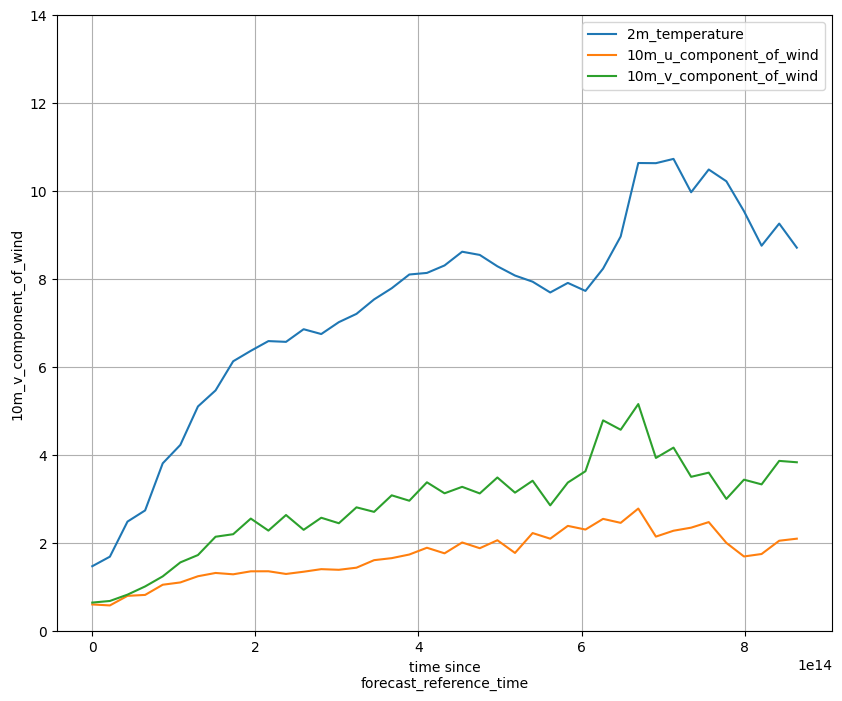

In [30]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
for n in rmse_era5_output.data_vars:
    rmse_era5_output[n].plot(ax=ax,label=n)
plt.ylim(0,14)
plt.legend()
plt.grid()
plt.show()

In [34]:
prepared_ghcn


<xarray.Dataset> Size: 736kB
Dimensions:                      (location: 79, valid_time: 385)
Coordinates:
    station                      (location) object 632B 'USI0000KCZT' ... 'US...
  * valid_time                   (valid_time) datetime64[ns] 3kB 2021-02-08T1...
  * location                     (location) object 632B MultiIndex
  * latitude                     (location) float64 632B 28.52 29.6 ... 31.15
  * longitude                    (location) float64 632B 260.2 263.7 ... 262.6
Data variables:
    2m_temperature               (location, valid_time) float64 243kB 288.1 ....
    surface_wind_speed           (location, valid_time) float64 243kB 1.5 ......
    surface_wind_from_direction  (location, valid_time) float64 243kB 120.0 ....

In [49]:
lons = xr.DataArray(
            prepared_ghcn["longitude"].values, dims="location"
        )
lats = xr.DataArray(
    prepared_ghcn["latitude"].values, dims="location"
)

prepared_forecast_for_ghcn = prepared_forecast.interp(latitude=lats, longitude=lons, method="nearest")
prepared_forecast_for_ghcn = prepared_forecast_for_ghcn.set_index(location=('latitude','longitude'))

#ghcn needs for wind to be swapped to vector from radial
prepared_ghcn['surface_eastward_wind'], prepared_ghcn['surface_northward_wind'] = wind_speed_direction_to_uv(prepared_ghcn['surface_wind_speed'], prepared_ghcn['surface_wind_from_direction'])

#modifying the name to match forecast; funnelling both into a consistent naming convention is important (used in ewb)
prepared_ghcn = prepared_ghcn.rename({'surface_eastward_wind':'10m_u_component_of_wind','surface_northward_wind':'10m_v_component_of_wind'})


In [50]:
rmse_ghcn_output = rmse(prepared_forecast_for_ghcn,prepared_ghcn,preserve_dims=['lead_time'])

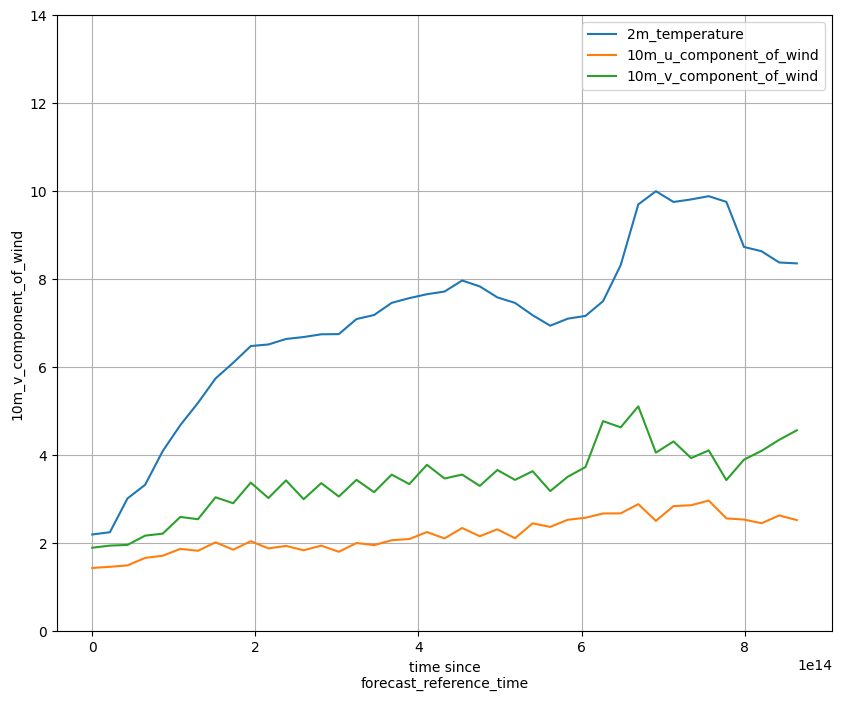

In [52]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
for n in rmse_ghcn_output.data_vars:
    rmse_ghcn_output[n].plot(ax=ax,label=n)
plt.ylim(0,14)
plt.legend()
plt.grid()
plt.show()

# Minimum Temperature MAE

Using the ERA5 spatial mean max to define the timestep of maximum temperature during the case

In [54]:
min_datetime = prepared_era5['2m_temperature'].sel(valid_time=prepared_era5.valid_time.dt.hour.isin([0,6,12,18])).mean(["latitude", "longitude"]).idxmin("valid_time").values
min_era5_avg_value = prepared_era5['2m_temperature'].mean(['latitude','longitude']).sel(valid_time=min_datetime)
min_ghcn_avg_value = prepared_ghcn['2m_temperature'].mean(['location']).sel(valid_time=min_datetime)

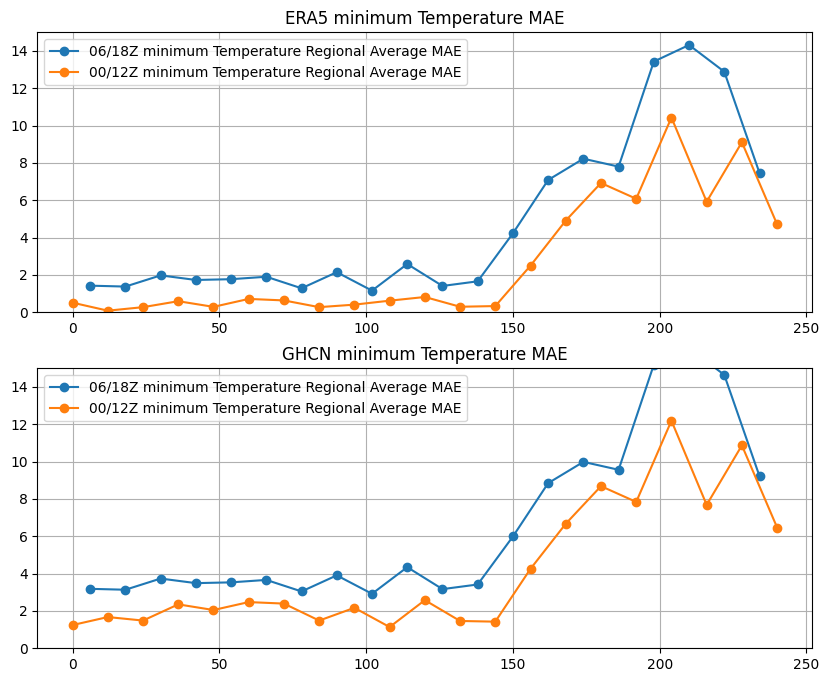

In [60]:
#ERA5 
filtered_min_forecast = remove_ocean_gridpoints(prepared_forecast).mean(['latitude','longitude']).where(
    (prepared_forecast.valid_time >= min_datetime - np.timedelta64(48, 'h')) & 
    (prepared_forecast.valid_time <= min_datetime + np.timedelta64(48, 'h')),
    drop=True
).min('valid_time')

#need to subset the variables here as filtered_min_forecast is a Dataset
min_era5_avg_mae = abs(filtered_min_forecast['2m_temperature'] - min_era5_avg_value)
min_ghcn_avg_mae = abs(filtered_min_forecast['2m_temperature'] - min_ghcn_avg_value)

fig, ax = plt.subplots(2,1,figsize=(10,8))
t=min_era5_avg_mae[1::2]['lead_time'].values.astype("timedelta64[h]")
ax[0].plot(t,min_era5_avg_mae[1::2],label='06/18Z minimum Temperature Regional Average MAE',marker='o')

t=min_era5_avg_mae[::2]['lead_time'].values.astype("timedelta64[h]")
ax[0].plot(t,min_era5_avg_mae[::2],label='00/12Z minimum Temperature Regional Average MAE',marker='o')

ax[0].set_title('ERA5 minimum Temperature MAE')
ax[0].legend()
ax[0].grid()
ax[0].set_ylim(0,15)
t = min_ghcn_avg_mae[1::2]['lead_time'].values.astype("timedelta64[h]")
ax[1].plot(t,min_ghcn_avg_mae[1::2],label='06/18Z minimum Temperature Regional Average MAE',marker='o')

t = min_ghcn_avg_mae[::2]['lead_time'].values.astype("timedelta64[h]")
ax[1].plot(t,min_ghcn_avg_mae[::2],label='00/12Z minimum Temperature Regional Average MAE',marker='o')

ax[1].set_title('GHCN minimum Temperature MAE')
ax[1].legend()
ax[1].grid()
ax[1].set_ylim(0,15)
plt.show()


# Onset ME

In [61]:
def min_if_all_timesteps_present_lead_time_valid_time_paradigm(x, num_timesteps: int = 4) -> xr.DataArray:
    """Return the minimum value of a DataArray if all timesteps of a day are present given a dataset with lead_time and valid_time dimensions.
    
    Args:
        da: The input DataArray.

    Returns:
        The minimum value of the DataArray if all timesteps are present, otherwise the original DataArray.
    """
    if len(x.valid_time) == num_timesteps:
        return x.min('valid_time')
    else:
        return xr.DataArray(np.nan)
    
    
def min_if_all_timesteps_present(x,num_timesteps: int) -> xr.DataArray:
    """Return the minimum value of a DataArray if all timesteps of a day are present.
    
    Args:
        da: The input DataArray.

    Returns:
        The minimum value of the DataArray if all timesteps are present, otherwise the original DataArray.
    """
    if len(x.values) == num_timesteps:
        return x.min()
    else:
        return xr.DataArray(np.nan)

In [62]:
onset_era5 = pd.Timestamp('2021-02-14 00:00')

In [63]:
def test_onset(x):
    if (x.valid_time.max() - x.valid_time.min()).values.astype('timedelta64[h]') >= 48:
        min_daily_vals = x.groupby('valid_time.dayofyear').map(min_if_all_timesteps_present,num_timesteps=4)
        # need to determine logic for 2+ consecutive days to find the date that the heatwave starts
        if len(min_daily_vals) >= 2:  # Check if we have at least 2 values
            for i in range(len(min_daily_vals)-1):
                if min_daily_vals[i] <= 273.15 and min_daily_vals[i+1] <= 273.15:
                    return xr.DataArray(x.where(x['valid_time'].dt.dayofyear==min_daily_vals.dayofyear[i],drop=True).valid_time[0].values)
                else:
                    return xr.DataArray(np.datetime64("NaT",'ns'))
        else:
            return xr.DataArray(np.datetime64("NaT",'ns'))
    else:
        return xr.DataArray(np.datetime64("NaT",'ns'))

In [65]:
# need to subset the variables here as prepared_forecast is a Dataset
onset_forecast = prepared_forecast['2m_temperature'].mean(['latitude','longitude']).groupby('init_time').map(test_onset)

onset_me = pd.to_datetime(onset_forecast) - onset_era5

onset_me

TimedeltaIndex([     NaT,      NaT,      NaT,      NaT,      NaT,      NaT,
                     NaT,      NaT,      NaT,      NaT,      NaT,      NaT,
                     NaT,      NaT,      NaT,      NaT,      NaT,      NaT,
                     NaT,      NaT,      NaT,      NaT,      NaT,      NaT,
                     NaT,      NaT,      NaT,      NaT,      NaT,      NaT,
                     NaT, '0 days',      NaT, '1 days',      NaT, '2 days',
                     NaT, '3 days',      NaT, '4 days',      NaT, '5 days',
                     NaT,      NaT,      NaT,      NaT,      NaT,      NaT,
                     NaT,      NaT,      NaT,      NaT,      NaT],
               dtype='timedelta64[ns]', freq=None)

# Duration ME

In [66]:
made_up_duration_number = 4

In [81]:
def test_duration(x):
    if (x.valid_time.max() - x.valid_time.min()).values.astype('timedelta64[h]') >= 48:
        min_daily_vals = x.groupby('valid_time.dayofyear').map(min_if_all_timesteps_present,num_timesteps=4)
        # need to determine logic for 2+ consecutive days to find the date that the heatwave starts
        if len(min_daily_vals) >= 2:  # Check if we have at least 2 values
            for i in range(len(min_daily_vals)-1):
                if min_daily_vals[i] <= 273.15 and min_daily_vals[i+1] <= 273.15:
                    consecutive_days = 2.  # Start with 2 since we found first pair
                    for j in range(i+2, len(min_daily_vals)):
                        if min_daily_vals[j] <= 273.15:
                            consecutive_days += 1
                        else:
                            break
                    return xr.DataArray(consecutive_days)
    return xr.DataArray(np.nan)
    
# need to subset the variables here as prepared_forecast is a Dataset
duration_forecast = prepared_forecast['2m_temperature'].mean(['latitude','longitude']).groupby('init_time').map(test_duration)
duration_me = duration_forecast - made_up_duration_number
duration_me

<xarray.DataArray (init_time: 53)> Size: 424B
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, -2., nan, -2., -2.,
       -2., nan, nan, nan, nan, nan, -2., -1., -2., -2., -2., -2.,  1.,
        1.,  1.,  1.,  1.,  2.,  2.,  1.,  1.,  0.,  0.,  0.,  0., -1.,
       -1., -2., -2., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan])
Coordinates:
  * init_time  (init_time) datetime64[ns] 424B 2021-01-29T12:00:00 ... 2021-0...